In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import pytz
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

import scipy.stats as stats
from sklearn.preprocessing import scale


from tensorflow import keras
from tensorflow.keras import layers # type: ignore
from tensorflow.keras import regularizers # type: ignore

## Preparación de datos

In [252]:
df_data = pd.read_csv('data_training/predictores_modelo_futuro.csv')
df_data['Datetime_hour'] = pd.to_datetime(df_data['Datetime_hour'])

df_data['Year'] = df_data['Datetime_hour'].dt.year
df_data['Month'] = df_data['Datetime_hour'].dt.month
df_data['Day_of_Week'] = df_data['Datetime_hour'].dt.dayofweek
df_data['Hour'] = df_data['Datetime_hour'].dt.hour

df_input = df_data.drop(columns=['Datetime_hour'])
print(df_data.info())
df_data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13678 entries, 0 to 13677
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Datetime_hour     13678 non-null  datetime64[ns]
 1   MD                13678 non-null  float64       
 2   Demanda           13678 non-null  float64       
 3   Gen.Eolica        13678 non-null  float64       
 4   Gen.Fotovoltaica  13678 non-null  float64       
 5   MD_lag_24         13678 non-null  float64       
 6   MD_lag_48         13678 non-null  float64       
 7   MD_lag_1week      13678 non-null  float64       
 8   IDA1_lag_24       13246 non-null  float64       
 9   IDA2_lag_24       13462 non-null  float64       
 10  Hour              13678 non-null  int32         
 11  Month             13678 non-null  int32         
 12  Day_of_week       13678 non-null  int64         
 13  FTB               13678 non-null  float64       
 14  FTS               1367

,Datetime_hour,MD,Demanda,Gen.Eolica,Gen.Fotovoltaica,MD_lag_24,MD_lag_48,MD_lag_1week,IDA1_lag_24,IDA2_lag_24,Hour,Month,Day_of_week,FTB,FTS,Precio_Gas,Precio_CO2_lag48,Year,Day_of_Week
0,2024-02-03 00:00:00,56.44,25367.3,6204.3,0.0,62.95,69.00,64.97,69.25,71.51,0,2,5,61.45,52.58,29.24,60.18,2024,5
1,2024-02-03 01:00:00,52.71,23677.3,5596.0,0.0,60.05,60.44,61.06,63.05,59.90,1,2,5,61.45,52.58,29.24,60.18,2024,5
2,2024-02-03 02:00:00,51.18,22408.5,5060.5,0.0,58.00,55.10,59.05,62.19,60.00,2,2,5,61.45,52.58,29.24,60.18,2024,5
3,2024-02-03 03:00:00,50.83,21695.8,4637.3,0.0,54.69,54.60,55.90,60.99,59.69,3,2,5,61.45,52.58,29.24,60.18,2024,5
4,2024-02-03 04:00:00,51.16,21351.0,4365.0,0.0,52.41,53.47,55.90,60.99,57.41,4,2,5,61.45,52.58,29.24,60.18,2024,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13673,2025-08-27 19:00:00,99.00,32531.8,7259.3,6590.3,103.14,114.78,69.27,129.80,132.77,19,8,2,67.93,36.11,33.22,71.48,2025,2
13674,2025-08-27 20:00:00,109.10,32869.3,7047.3,1385.5,117.00,125.95,78.73,127.76,136.32,20,8,2,67.93,36.11,33.22,71.48,2025,2
13675,2025-08-27 21:00:00,114.32,33576.3,6865.5,1.0,123.46,142.00,100.07,122.46,130.87,21,8,2,67.93,36.11,33.22,71.48,2025,2
13676,2025-08-27 22:00:00,113.63,31407.5,6833.3,0.0,113.12,123.11,97.52,114.12,119.91,22,8,2,67.93,36.11,33.22,71.48,2025,2


## Baseline

In [125]:
# Estimacion: Precio igual al día anterior
df_input["MD_pred"] = df_input["MD"].shift(24)
df_clean = df_input.dropna(subset=["MD", "MD_pred"])
mae = mean_absolute_error(df_clean["MD"], df_clean["MD_pred"])
print(mae)

18.749266149113815


In [126]:
# Estimacion: Precio igual al mismo día de la semana anterior
df_input["MD_pred"] = df_input["MD"].shift(24*7)
df_clean = df_input.dropna(subset=["MD", "MD_pred"])
mae = mean_absolute_error(df_clean["MD"], df_clean["MD_pred"])
print(mae)

df_input.drop(columns=["MD_pred"], inplace=True)

27.97921761658031


# Modelo Dense Neural Network

PARAMETROS

In [ ]:
# MEJOR COMBINACION PARA ULTIMOS 14 DIAS  -- 9.09
# n_neurons_1 = 64
# n_neurons_2 = 64
# dropout = 0.25

# lr = 0.0005
# patience = 12
# batch_size = 64
# cols_drop = ['IDA1_lag_24', 'IDA2_lag_24']

In [ ]:
num_test_days = 14
num_val_days = 14


n_neurons_1 = 64
n_neurons_2 = 64
dropout = 0.25

lr = 0.0005
patience = 12
batch_size = 64

cols_drop = ['IDA1_lag_24', 'IDA2_lag_24']

### Split train - test

In [254]:
df_input = df_input.drop(columns=[x for x in cols_drop if x in df_input.columns])
df_input.dropna(inplace=True)
print(df_input.info())


X_train = df_input.drop('MD', axis=1).iloc[:len(df_input)-num_test_days*24-num_val_days*24]
X_val = df_input.drop('MD', axis=1).iloc[-num_test_days*24-num_val_days*24:-num_test_days*24]
X_test = df_input.drop('MD', axis=1).iloc[-num_test_days*24:]

y_train = df_input['MD'].iloc[:len(df_input)-num_test_days*24-num_val_days*24]
y_val = df_input['MD'].iloc[-num_test_days*24-num_val_days*24:-num_test_days*24]
y_test = df_input['MD'].iloc[-num_test_days*24:]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13678 entries, 0 to 13677
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   MD                13678 non-null  float64
 1   Demanda           13678 non-null  float64
 2   Gen.Eolica        13678 non-null  float64
 3   Gen.Fotovoltaica  13678 non-null  float64
 4   MD_lag_24         13678 non-null  float64
 5   MD_lag_48         13678 non-null  float64
 6   MD_lag_1week      13678 non-null  float64
 7   Month             13678 non-null  int32  
 8   Day_of_week       13678 non-null  int64  
 9   FTB               13678 non-null  float64
 10  FTS               13678 non-null  float64
 11  Precio_Gas        13678 non-null  float64
 12  Precio_CO2_lag48  13678 non-null  float64
 13  Year              13678 non-null  int32  
 14  Day_of_Week       13678 non-null  int32  
dtypes: float64(11), int32(3), int64(1)
memory usage: 1.4 MB
None


Normalizacion

In [255]:
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_train_scaled = scaler_X.fit_transform(X_train)
X_val_scaled = scaler_X.transform(X_val)
X_test_scaled = scaler_X.transform(X_test)

# Para la variable objetivo
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1)).flatten()
y_val_scaled = scaler_y.transform(y_val.values.reshape(-1, 1)).flatten()
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1)).flatten()

### Modelo: Dense Neural Network

In [256]:
n_features = X_train.shape[1]

# Entrada
inputs = keras.Input(shape=(n_features,))
# Primera capa interna
x = layers.Dense(n_neurons_1, activation='relu', kernel_regularizer=regularizers.l2(1e-4))(inputs)
x = layers.BatchNormalization()(x)
x = layers.Dropout(dropout)(x)
# Segunda capa interna
x = layers.Dense(n_neurons_2, activation='relu', kernel_regularizer=regularizers.l2(1e-4))(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(dropout)(x)
# Tercera capa interna
x = layers.Dense(n_neurons_2, activation='relu', kernel_regularizer=regularizers.l2(1e-4))(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(dropout)(x)
# Salida
outputs = layers.Dense(1)(x)
# Construccion del modelo
model = keras.Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=lr),
    loss='mse',
    metrics=['mae']  # MAE como métrica principal
)

In [257]:
callbacks = [
    keras.callbacks.EarlyStopping(
        monitor='val_mae',  # Monitorear MAE de validation
        patience=patience,
        restore_best_weights=True,
        verbose=1
    ),
    keras.callbacks.ModelCheckpoint(
        'modelo_futuro.keras',
        monitor='val_mae',
        save_best_only=True,
        verbose=1
    )
]
history = model.fit(
    X_train_scaled, y_train_scaled,
    validation_data=(X_val_scaled, y_val_scaled),  # Usar validation set
    epochs=150,
    batch_size=batch_size,
    callbacks=callbacks,
    verbose=1
)


Epoch 1/150
192/204 [===========================>..] - ETA: 0s - loss: 1.2476 - mae: 0.8575
Epoch 1: val_mae improved from inf to 0.46994, saving model to modelo_futuro.keras
204/204 [==============================] - 2s 3ms/step - loss: 1.2255 - mae: 0.8490 - val_loss: 0.3169 - val_mae: 0.4699
Epoch 2/150
199/204 [============================>.] - ETA: 0s - loss: 0.6511 - mae: 0.6261
Epoch 2: val_mae improved from 0.46994 to 0.30340, saving model to modelo_futuro.keras
204/204 [==============================] - 0s 2ms/step - loss: 0.6482 - mae: 0.6246 - val_loss: 0.1647 - val_mae: 0.3034
Epoch 3/150
193/204 [===========================>..] - ETA: 0s - loss: 0.4532 - mae: 0.5186
Epoch 3: val_mae improved from 0.30340 to 0.29143, saving model to modelo_futuro.keras
204/204 [==============================] - 0s 2ms/step - loss: 0.4496 - mae: 0.5163 - val_loss: 0.1498 - val_mae: 0.2914
Epoch 4/150
194/204 [===========================>..] - ETA: 0s - loss: 0.3304 - mae: 0.4398
Epoch 4: val

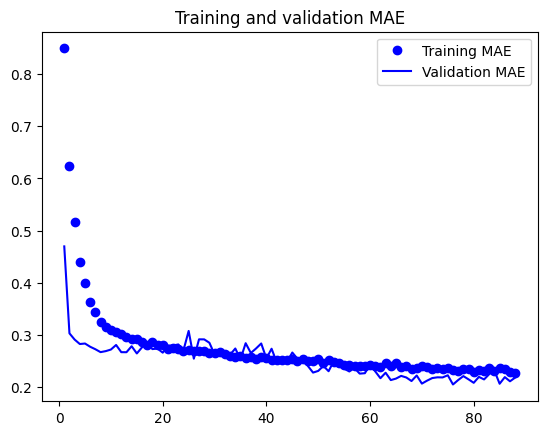

In [258]:
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

In [259]:
# Evaluar el modelo con el test set (datos nunca vistos)
print("\n" + "="*50)
print("EVALUACIÓN FINAL CON TEST SET")
print("="*50)

# Hacer predicciones en el test set
y_pred_scaled = model.predict(X_test_scaled)
y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()
y_real = scaler_y.inverse_transform(y_test_scaled.reshape(-1, 1)).flatten()


# MAE
mae_test = mean_absolute_error(y_real, y_pred)
print(f"MAE en Test Set: {mae_test:.2f} €/MWh")
print(f"Error absoluto medio: ±{mae_test:.2f} €/MWh")


fechas_test = df_data['Datetime_hour'].iloc[-num_test_days*24:]

# Crear un DataFrame con los datos para Plotly
df_plot = pd.DataFrame({
    'Fecha': fechas_test,
    'Valor Real': y_real,
    'Predicción': y_pred
})

# Crear el gráfico interactivo con Plotly Express
fig = px.line(df_plot, x='Fecha', y=['Valor Real', 'Predicción'],
              title='Predicciones vs Valores Reales (Test Set)',
              labels={'value': 'Precio (Escala Original)', 'variable': 'Leyenda'},
              color_discrete_map={'Valor Real': 'blue', 'Predicción': 'orange'})

# Personalizar el gráfico
fig.update_layout(
    title_font_size=16,
    xaxis_title='Fecha',
    xaxis_title_font_size=14,
    yaxis_title='Precio (Escala Original)',
    yaxis_title_font_size=14,
    legend_title='',
    width=1000,
    height=500,
    template='plotly_white'
)

# Ajustar la opacidad de la línea de predicción
fig.update_traces(opacity=0.7, selector={'name': 'Predicción'})

# Mostrar la cuadrícula
fig.update_xaxes(showgrid=True)
fig.update_yaxes(showgrid=True)

# Mostrar el gráfico
fig.show()


EVALUACIÓN FINAL CON TEST SET
11/11 [==============================] - 0s 801us/step
MAE en Test Set: 10.35 €/MWh
Error absoluto medio: ±10.35 €/MWh


# Evaluacion final